<a href="https://colab.research.google.com/github/andreas31603/MachineLearningTasks/blob/main/Task14/RNN_dan_Deep_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


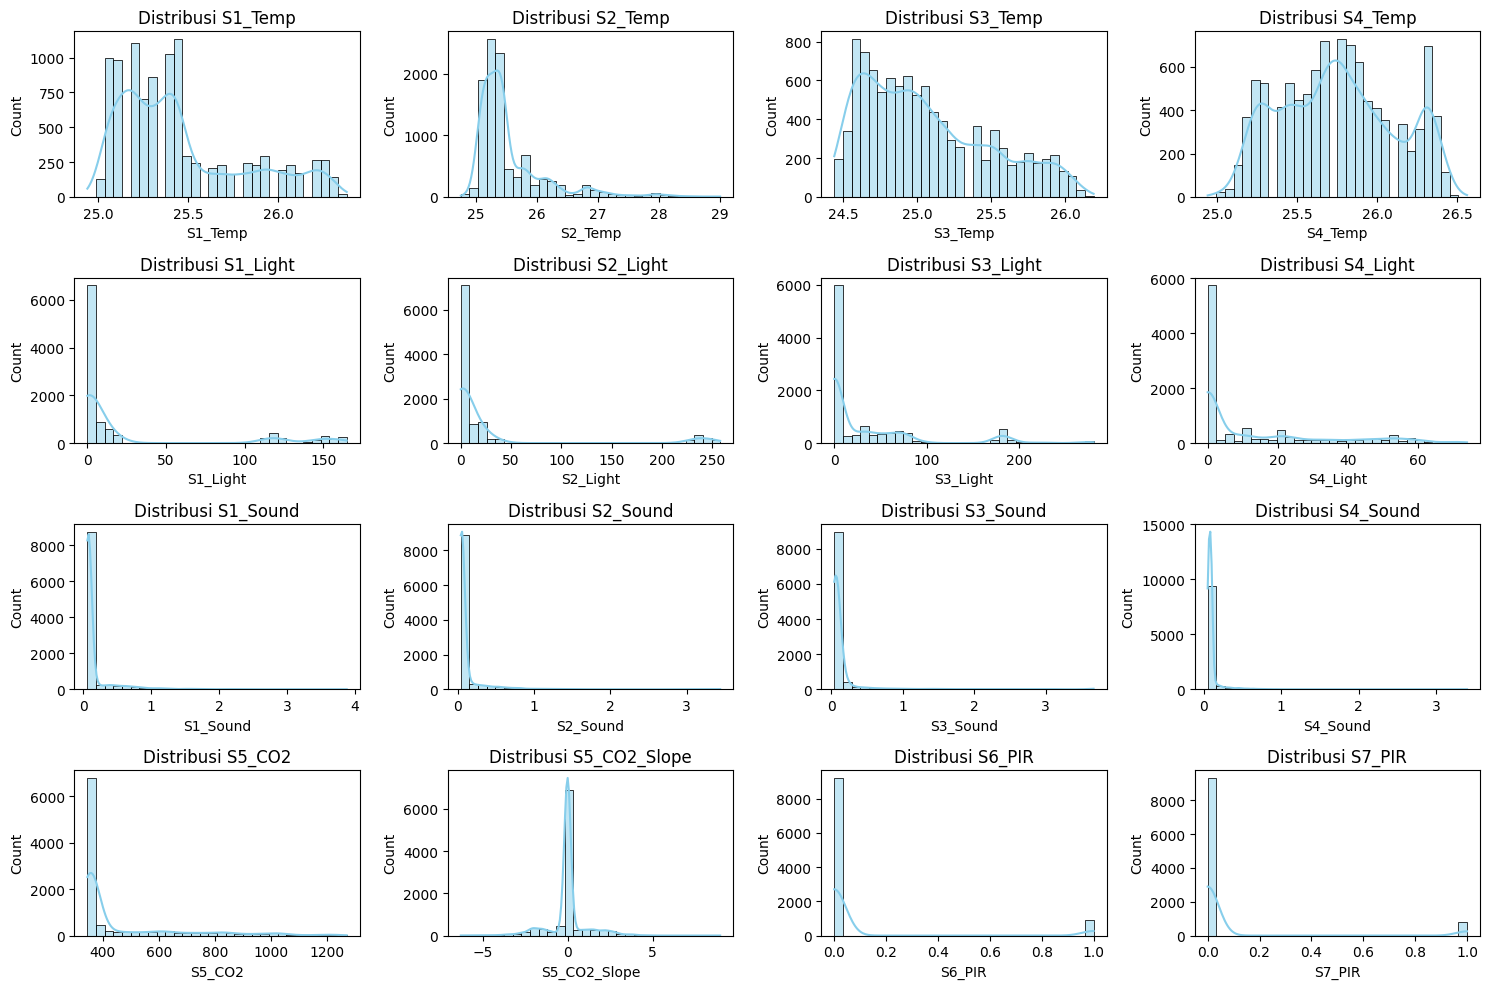

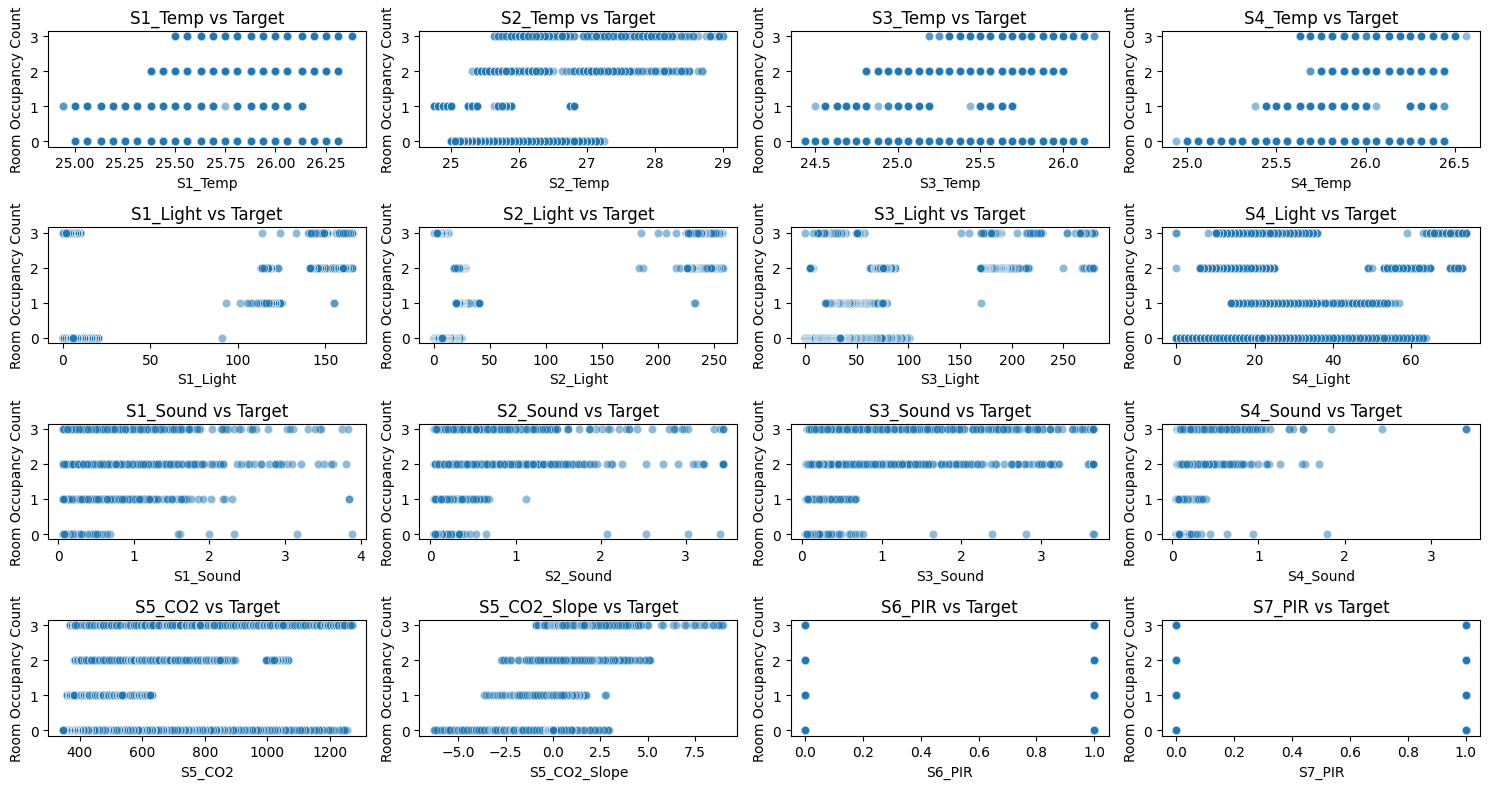

Korelasi dengan Target:
Room_Occupancy_Count    1.000000
S1_Light                0.849058
S3_Light                0.793081
S2_Light                0.788764
S1_Temp                 0.700868
S7_PIR                  0.695138
S2_Temp                 0.671263
S5_CO2                  0.660144
S3_Temp                 0.652047
S6_PIR                  0.633133
S5_CO2_Slope            0.601105
S1_Sound                0.573748
S2_Sound                0.557853
S3_Sound                0.531685
S4_Temp                 0.526509
S4_Sound                0.460287
S4_Light                0.355715
Name: Room_Occupancy_Count, dtype: float64

Model Type: Simple RNN

Pooling: max, Optimizer: SGD, Epochs: 5
Epoch 1/5, Training Loss: 0.8854, Validation Loss: 0.7614
Epoch 2/5, Training Loss: 0.6930, Validation Loss: 0.6345
Epoch 3/5, Training Loss: 0.5952, Validation Loss: 0.5595
Epoch 4/5, Training Loss: 0.5298, Validation Loss: 0.5020
Epoch 5/5, Training Loss: 0.4766, Validation Loss: 0.4515

Pooling: max, Op

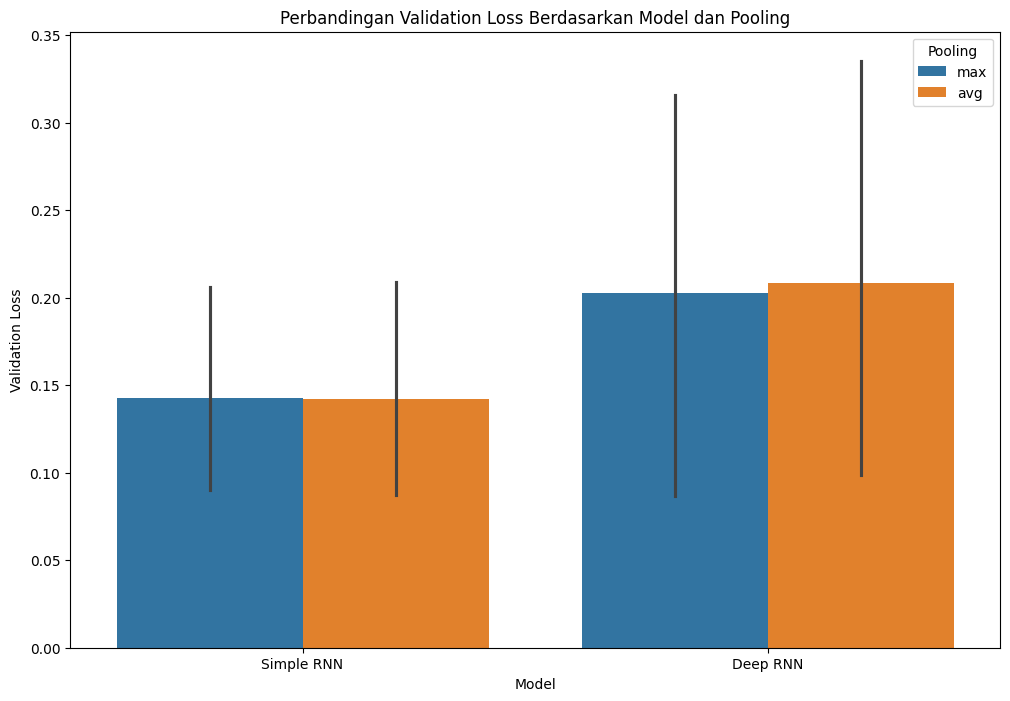

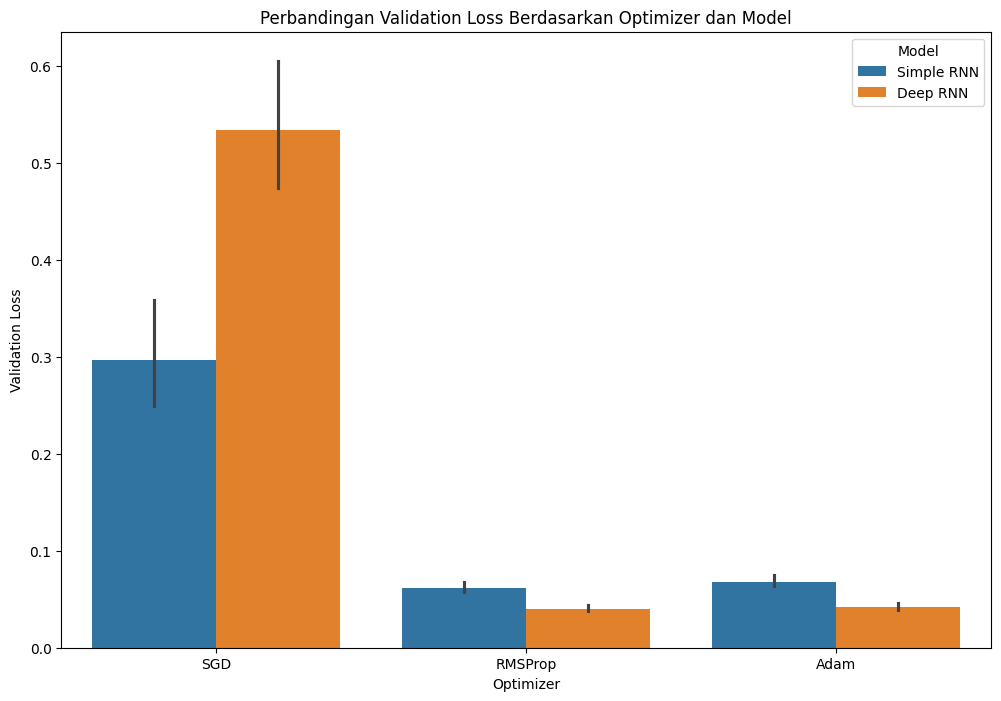

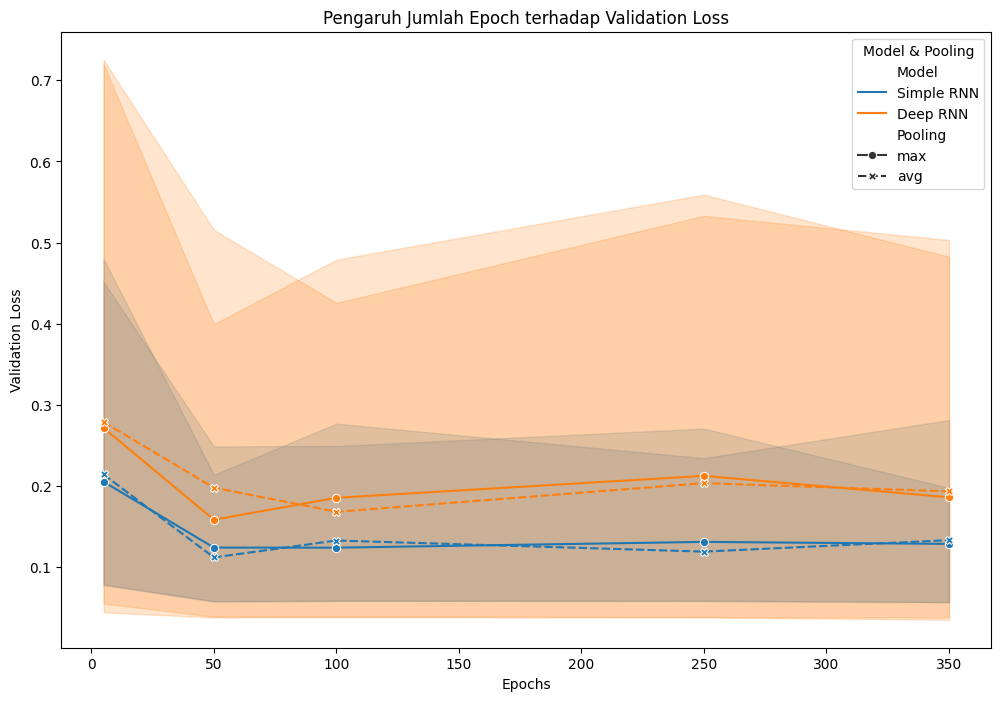

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ================================
# Data Preparation and Preprocessing
# ================================

# Memuat dataset
file_path = '/content/drive/MyDrive/RNN/Occupancy_Estimation.csv'
data = pd.read_csv(file_path)

# Memisahkan fitur dan target
features = data.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])
target = data['Room_Occupancy_Count']

# EDA dan Visualisasi Data
# Statistik deskriptif
eda_stats = data.describe()

# Visualisasi distribusi setiap fitur
plt.figure(figsize=(15, 10))
for i, col in enumerate(features.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(features[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribusi {col}")
plt.tight_layout()
plt.show()

# Hubungan antara fitur dan target
plt.figure(figsize=(15, 8))
for i, col in enumerate(features.columns, 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(x=features[col], y=target, alpha=0.5)
    plt.title(f"{col} vs Target")
    plt.xlabel(col)
    plt.ylabel("Room Occupancy Count")
plt.tight_layout()
plt.show()

# Korelasi antara fitur dan target
correlation_with_target = data.drop(columns=['Date', 'Time']).corr()['Room_Occupancy_Count'].sort_values(ascending=False)
print("Korelasi dengan Target:")
print(correlation_with_target)

# Normalisasi fitur
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Split dataset menjadi train, validation, dan test set
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(features_normalized, target, test_size=0.3, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Konversi dataset ke dalam bentuk tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Membuat DataLoader untuk membagi data ke dalam batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ================================
# RNN Model Definition
# ================================

class SimpleRNNWithPooling(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling='max'):
        super(SimpleRNNWithPooling, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h_0)
        if self.pooling == 'max':
            out, _ = torch.max(out, dim=1)
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

# ================================
# Deep RNN Model Definition
# ================================

class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, pooling='max'):
        super(DeepRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h_0)
        if self.pooling == 'max':
            out, _ = torch.max(out, dim=1)
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

# ================================
# Training and Evaluation Functions
# ================================

criterion = nn.MSELoss()
optimizers = {
    'SGD': optim.SGD,
    'RMSProp': optim.RMSprop,
    'Adam': optim.Adam
}

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Fungsi untuk melatih dan mengevaluasi model dengan epoch dan optimizer
epochs_list = [5, 50, 100, 250, 350]

results = []

def train_and_evaluate(train_loader, val_loader, model_class, input_size, hidden_size, output_size, epochs, optimizer_name, pooling, num_layers=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model_class(input_size, hidden_size, output_size, num_layers, pooling).to(device) if model_class == DeepRNN else model_class(input_size, hidden_size, output_size, pooling).to(device)
    optimizer = optimizers[optimizer_name](model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    early_stopper = EarlyStopping(patience=10)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                val_loss += criterion(outputs.squeeze(), y_batch).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

        if early_stopper.step(val_loss):
            print("Early stopping triggered.")
            break

    return val_loss

# Eksperimen dengan kombinasi hyperparameter
for model_class in [SimpleRNNWithPooling, DeepRNN]:
    model_type = "Simple RNN" if model_class == SimpleRNNWithPooling else "Deep RNN"
    print(f"\nModel Type: {model_type}")
    for pooling in ['max', 'avg']:
        for optimizer_name in optimizers.keys():
            for epochs in epochs_list:
                print(f"\nPooling: {pooling}, Optimizer: {optimizer_name}, Epochs: {epochs}")
                val_loss = train_and_evaluate(train_loader, val_loader, model_class, X_train.shape[1], 64, 1, epochs, optimizer_name, pooling, num_layers=3 if model_class == DeepRNN else 1)
                results.append((model_type, pooling, optimizer_name, epochs, val_loss))

# Menampilkan hasil eksperimen
sorted_results = sorted(results, key=lambda x: x[4])
print("\nHasil Terbaik:")
for res in sorted_results[:5]:
    print(f"Model: {res[0]}, Pooling: {res[1]}, Optimizer: {res[2]}, Epochs: {res[3]}, Validation Loss: {res[4]:.4f}")

# ================================
# Visualization of Results
# ================================

# Membuat DataFrame dari hasil eksperimen
results_df = pd.DataFrame(results, columns=['Model', 'Pooling', 'Optimizer', 'Epochs', 'Validation Loss'])

# Visualisasi perbandingan model
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Model', y='Validation Loss', hue='Pooling')
plt.title('Perbandingan Validation Loss Berdasarkan Model dan Pooling')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.legend(title='Pooling')
plt.show()

# Visualisasi perbandingan optimizer
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Optimizer', y='Validation Loss', hue='Model')
plt.title('Perbandingan Validation Loss Berdasarkan Optimizer dan Model')
plt.xlabel('Optimizer')
plt.ylabel('Validation Loss')
plt.legend(title='Model')
plt.show()

# Visualisasi pengaruh jumlah epoch
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Epochs', y='Validation Loss', hue='Model', style='Pooling', markers=True)
plt.title('Pengaruh Jumlah Epoch terhadap Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(title='Model & Pooling')
plt.show()
